In [17]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import sys
import os
from pathlib import Path
from importlib import reload

sys.path.append('../')
import waveform_processing as proc
reload(proc)

<module 'waveform_processing' from '../waveform_processing.py'>

In [18]:
plt.style.use('dark_background')
#matplotlib.rcParams.keys()
plt.rcParams['figure.figsize'] = (10, 6)
plt.rc('font', size=12)
length = 8
width = 1.5
plt.rcParams['xtick.major.size'] = length
plt.rcParams['ytick.major.size'] = length
plt.rcParams['xtick.major.width'] = width
plt.rcParams['ytick.major.width'] = width

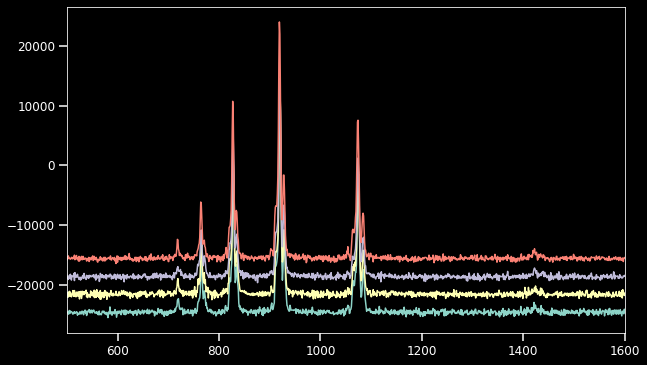

In [19]:
exp_name = 'sxrx21715'
run = 104
fname = './GMD_{}_r{}.csv'.format(exp_name, str(run))
dat = np.loadtxt(fname, delimiter=',')

plt.plot(dat[:4].T+[0,3000,6000,9000])
plt.xlim(500,1600)
plt.show()

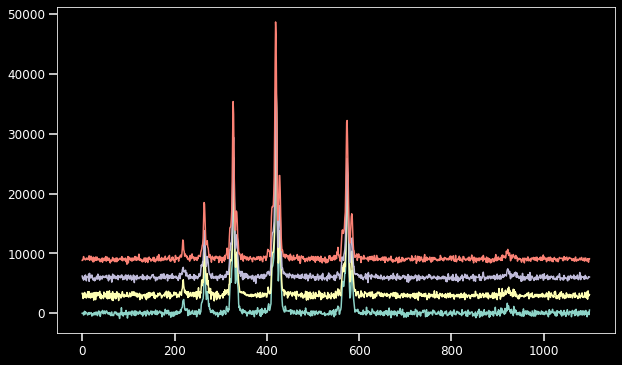

In [20]:
def removeBackground(signal, ave_window=[0,500]):
    """
    Set the baseline of the waveform to 0
    """
    if signal.ndim ==1:
        return signal - np.median(signal[ave_window[0]:ave_window[1]])
    elif signal.ndim==2:
        med = np.median(signal[:,ave_window[0]:ave_window[1]], axis=1)  
        return signal - med.reshape(med.shape[0],1)
    
dat = removeBackground(dat, ave_window=[0,500])
dat = dat[:,500:1600]

plt.plot(dat[:4].T+[0,3000,6000,9000])
plt.show()

# Fit with single basis for the whole curve

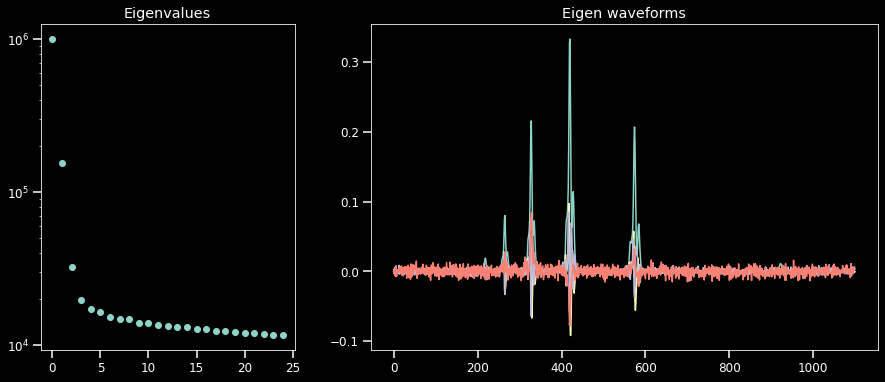

In [21]:
n_c = 2
A, proj, svd = proc.get_basis_and_projector(dat[:100], n_components=n_c)

fig, ax = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios':[1,2]})
ax[0].set_title('Eigenvalues')
ax[0].plot(svd.singular_values_,'o')
ax[0].set_yscale('log')
ax[1].set_title('Eigen waveforms')
ax[1].plot(svd.components_[0])
ax[1].plot(0.3*svd.components_[1])
ax[1].plot(0.3*svd.components_[2])
ax[1].plot(0.3*svd.components_[3])
plt.show()

In [22]:
n_c = 2
regr = proc.construct_waveformRegressor(dat[:100], n_components=n_c)
reconstructed = regr.fit_reconstruct(dat)
intensities = np.squeeze(regr.get_pulse_intensity(dat))
score = regr.score(dat)

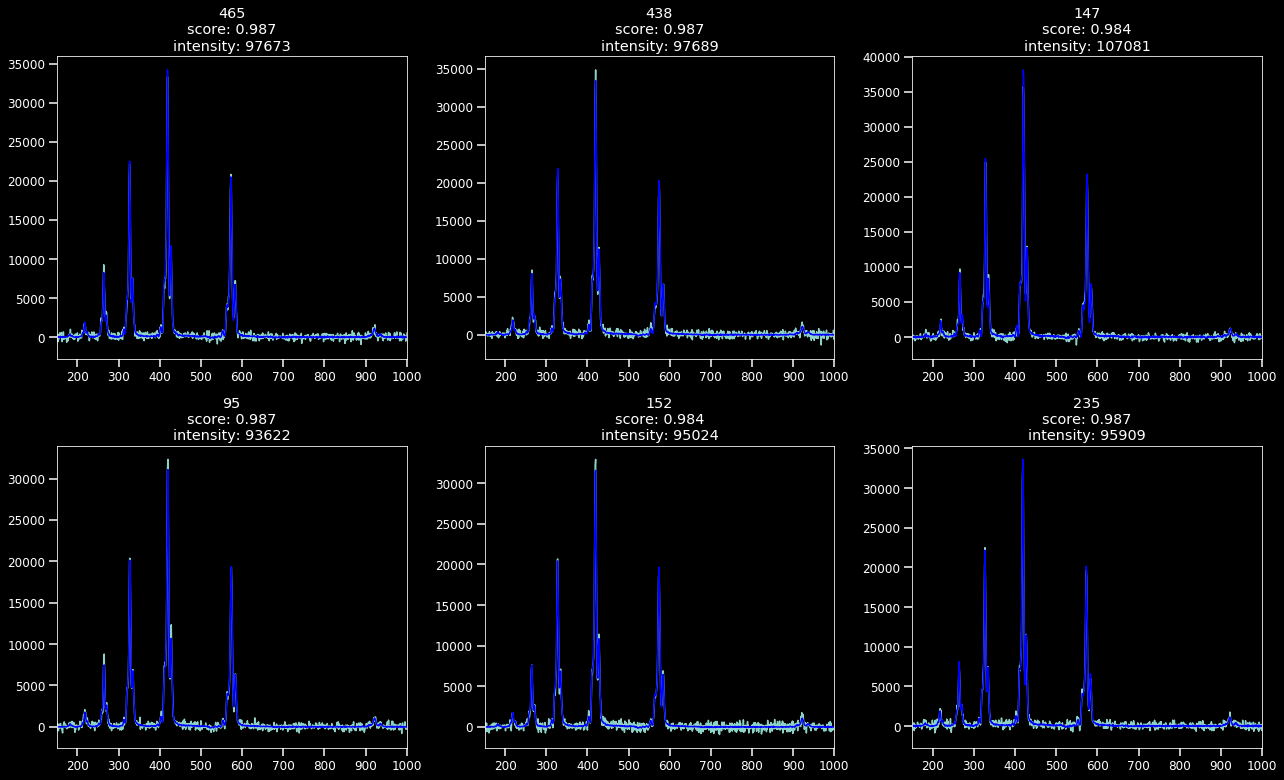

In [23]:
fig, ax = plt.subplots(2,3, figsize=(18,11))
ax = np.ravel(ax)
for ii in range(6):
    idx = np.random.randint(dat.shape[0])
    ax[ii].plot(dat[idx])
    ax[ii].plot(reconstructed[idx], 'b')
    ax[ii].set_title('{}\nscore: {:.3f}\nintensity: {:.0f}'.format(str(idx), score[idx], intensities[idx]))
    ax[ii].set_xlim(150,1000)
plt.tight_layout()
plt.show()

This approach will give one common intensity for all peaks at each shot. Is it what is needed?

# Fit with a different basis for each peak

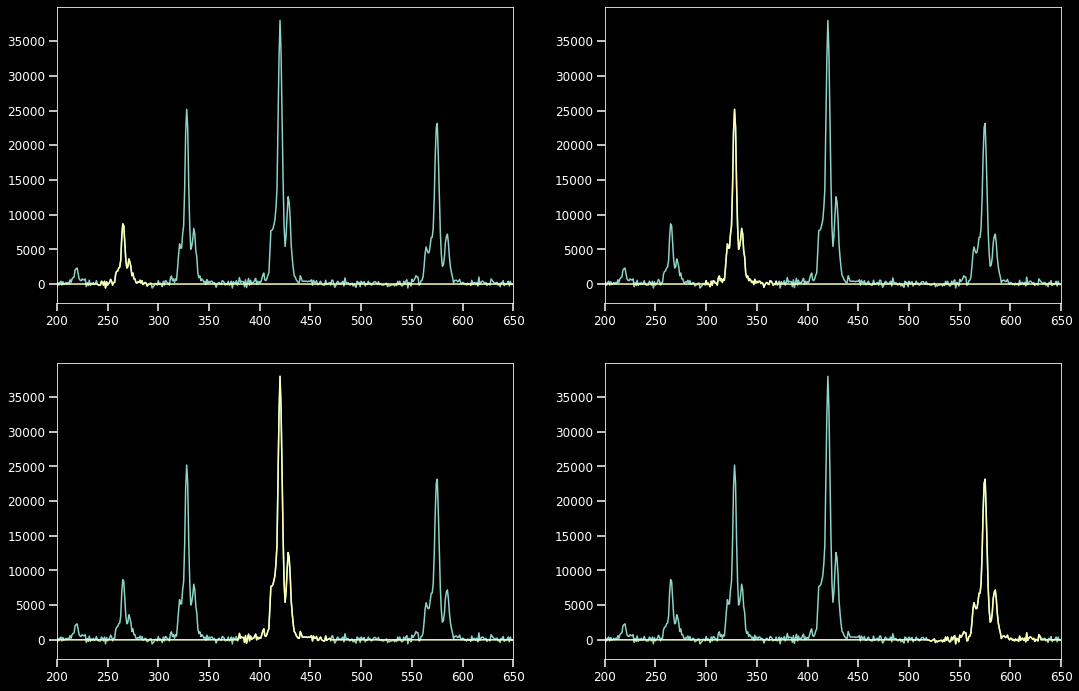

In [9]:
# index range for each peak
p1 = [240, 290]
p2 = [300,370]
p3 = [380,470]
p4 = [520,630]
peaks = np.vstack([p1,p2,p3,p4])

dat_single = []
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = np.ravel(ax)
for ii, p in enumerate(peaks):
    ax[ii].plot(dat[0])
    temp = np.copy(dat)
    temp[:,:p[0]] = 0
    temp[:,p[1]:] = 0
    dat_single.append(temp)
    ax[ii].plot(temp[0])
    ax[ii].set_xlim(200,650)

In [10]:
n_c = 3
A = []
proj = []
for ii, dat_s in enumerate(dat_single):
    temp_a, temp_proj, svd = proc.get_basis_and_projector(dat_s, n_components=n_c)
    A.append(temp_a)
    proj.append(temp_proj)
A = np.concatenate(A, axis=1)
proj = np.concatenate(proj, axis=0)

print(A[:,0].dot(A[:,2]))

-1.5439038936193583e-16


The multipulse basis is ortogonal. This is thanks fo the fact that the different pulses do not overlap.

(200, 650)

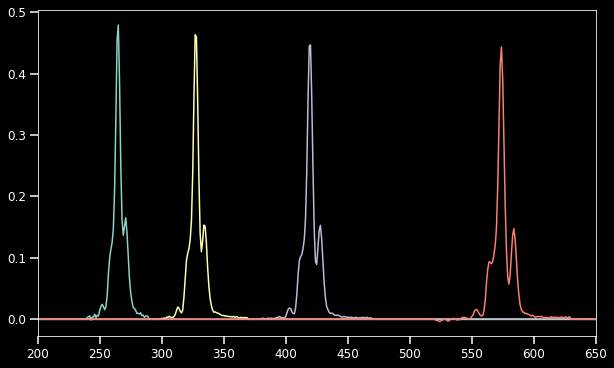

In [11]:
fig, ax = plt.subplots()
for ii in np.arange(0,4*n_c, n_c):
    ax.plot(A[:,ii])
ax.set_xlim(200,650)

In [12]:
regr4 = proc.WaveformRegressor(A=A, projector=proj, n_pulse=4)
reconstructed = regr4.fit_reconstruct(dat)
intensities = regr4.get_pulse_intensity(dat)
intensities_max = regr4.get_pulse_intensity(dat, mode='max')
score = regr4.score(dat)

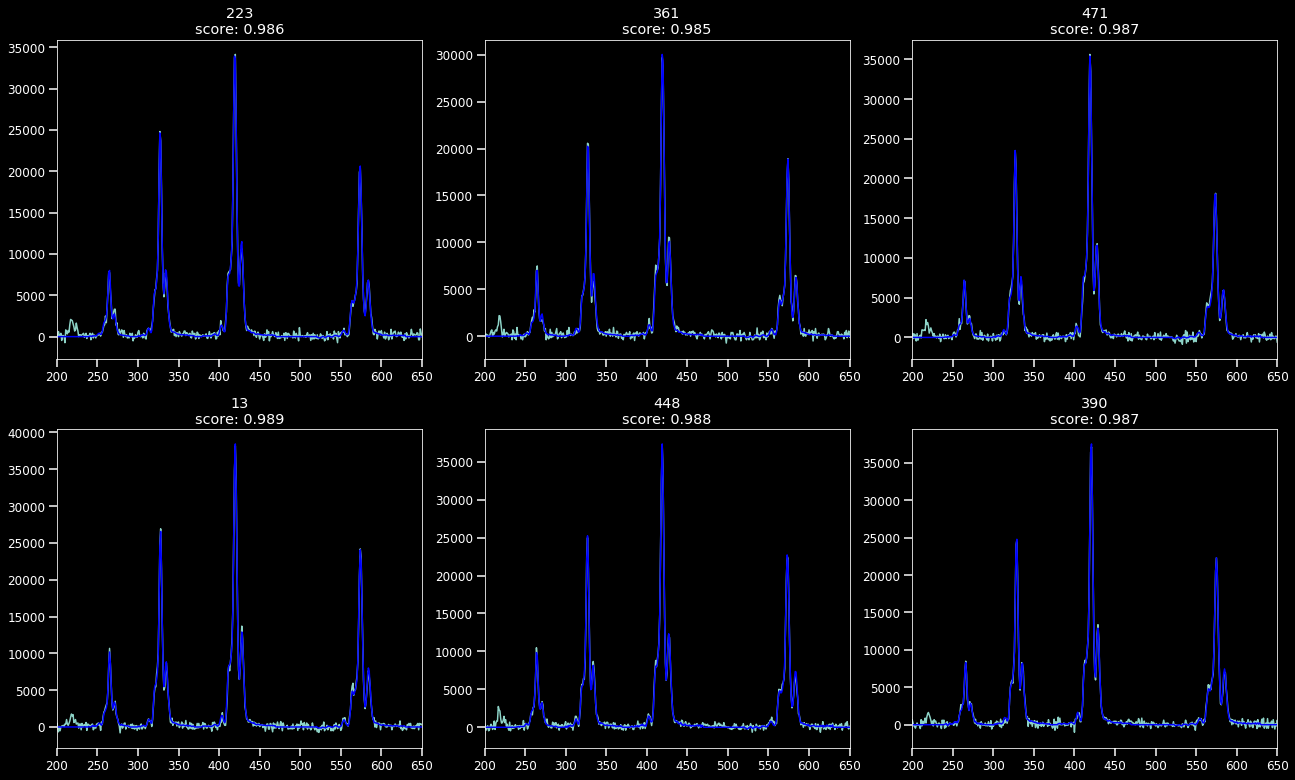

In [13]:
fig, ax = plt.subplots(2,3, figsize=(18,11))
ax = np.ravel(ax)
for ii in range(6):
    idx = np.random.randint(dat.shape[0])
    ax[ii].plot(dat[idx])
    ax[ii].plot(reconstructed[idx], 'b')
    ax[ii].set_title('{}\nscore: {:.3f}'.format(str(idx), score[idx]))
    ax[ii].set_xlim(200,650)
plt.tight_layout()
plt.show()

In [14]:
ii = 5
print(intensities[ii,0]/intensities[ii,1])
print(intensities_max[ii,0]/intensities_max[ii,1])
print('\n')

print(intensities[ii,1]/intensities[ii,2])
print(intensities_max[ii,1]/intensities_max[ii,2])
print('\n')

print(intensities[ii,2]/intensities[ii,3])
print(intensities_max[ii,2]/intensities_max[ii,3])

0.3554929256009479
0.3572538041459609


0.6227991105735674
0.657633429344111


1.5420159095263615
1.5791846471654862
